<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/model%20layers%20pop/Middle%20verification%20_TP-FN_TN-FP_FAR-FFR-EER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
* verification with middle of data --- test threshold

subject number = 109 >> 90 train subject  + 19 new subject 
channel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]

model3 -  1 layer pop

'''


'\ncounter true and false verification\n\nsubject number = 109 >> 90 train subject  + 19 new subject \nchannel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]\n\nmodel3 -  1 layer pop\n\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install mne

     |████████████████████████████████| 6.4MB 52kB/s 


In [3]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:
# Parameters:

EpochNum=60
subject_numberT=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =160  # outer step len
#sample_per_window = 160
window_len= 20
batch_size=64




In [5]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import itertools
from itertools import combinations 
import statistics
import csv
import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model



# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Automatically created module for IPython interactive environment


In [6]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_numberT
for x in range(subject_numberT):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_numberT,task_number), dtype='object')

for i in range(subject_numberT):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Do you want to set the path:
    /content/drive/My Drive/Deep Results/Database
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.in

In [7]:
subject_number = 90
# new subject
new_subject =np.arange(subject_number, subject_numberT)

# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = len(subject_img_number_array_shuffled)//2
val_index = train_index + len(subject_img_number_array_shuffled)//4

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)
print(train_number , val_number, test_number)
subject_img_number


29 14 16


59

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    e= 0    
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        
        for i in range(len(ListChannel)):
            DataChannelsRaw[e][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[e][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[e][i])) # min for each cannel

            DataChannelsNormal[e][i]=normalize_channel_data(DataChannelsRaw[e][i].copy(), i, ch_min, ch_max)
        e = e+1

        # Orthogonal Channel
        #DataChannelsOrt[e][0]=DataChannelsNormal[e][0]
        #DataChannelsOrt[e][1]=DataChannelsNormal[e][1]-ProjectionVector(DataChannelsNormal[e][0].copy(),DataChannelsNormal[e][1].copy())*OrthogonalFlag
        
        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          r = 0
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsNormal[r][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data
              r=r+1

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,subject_numberT)
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [0]:
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()


In [0]:
#model.save('/content/drive/My Drive/mymodels/model1.h5')

In [12]:
model = load_model('/content/drive/My Drive/mymodels/model2_2.h5')
model.summary()
model.pop()
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 160, 64)       11584     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 80, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 78, 128)        73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 39, 128)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 37, 256)        295168    
____________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
def subject_Predict_generator(batch_size, mymodel, subject_arr, img_arr ):
  sn = len(subject_arr)
  imgn = len(img_arr)
  pre_GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_arr,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled= img_arr)

  pre_Subject = mymodel.predict_generator(pre_GenTestData,steps=np.ceil(imgn*sn/batch_size))
  return pre_Subject


In [17]:

path = "/content/drive/My Drive/middle_variance vrifi"

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory /content/drive/My Drive/middle_variance vrifi failed


In [0]:
### calculate the median and variance of sample median

def calc_mid_var(subject_instance_num, start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  same_list_result = []
  diff_list_result = []

  Same_ResultFileName =str(subject_instance_num)+ "outer shift 160_ Same subject _middle_variance " + "S1(" + str(start_index_s1) + '-' + str(end_index_s1) + ')'+'.csv'
  Diff_ResultFileName = "outer shift 160_ Different subject _middle_variance " + "S1(" + str(start_index_s1) + '-' + str(end_index_s1) + ')' + "_S2("+ str(start_index_s2) + '-' + str(end_index_s2) + ')'+'.csv'

  for i in range(subject_instance_num):

    # same subject
    same_list_dist = []
    S1_rand = random.randint(start_index_s1, end_index_s1)
    pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
    np.random.shuffle(pre_subject_img_number_array_shuffled)
    
    pre_S1_rand = subject_Predict_generator(64, model, [S1_rand], pre_subject_img_number_array_shuffled)
    
    for i in range(len(pre_S1_rand)-1):
      dist = distance.euclidean(pre_S1_rand[i] , pre_S1_rand[i+1]) 
      same_list_dist.append(dist)
    #variance   
    same_variance_dist = statistics.variance(same_list_dist) 
    #middle
    same_middle_dist = statistics.median_low(same_list_dist)
    same_list_result.append([S1_rand,S1_rand, same_middle_dist, same_variance_dist])


    #different
    diff_list_dist = []
    S2_rand = random.randint(start_index_s2, end_index_s2)
    while S2_rand == S1_rand:
          S2_rand = random.randint(start_index_s2, end_index_s2)
    pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
    np.random.shuffle(pre_subject_img_number_array_shuffled)

    pre_S2_rand = subject_Predict_generator(64, model, [S2_rand], pre_subject_img_number_array_shuffled)
    
    for i in range(len(pre_S1_rand)):
      dist = distance.euclidean(pre_S1_rand[i] , pre_S2_rand[i]) 
      diff_list_dist.append(dist)
    #variance   
    diff_variance_dist = statistics.variance(diff_list_dist) 
    #middle
    diff_middle_dist = statistics.median_low(diff_list_dist)
    diff_list_result.append([S1_rand, S2_rand, diff_middle_dist, diff_variance_dist])

  ##save resulte
  # same subject file
  with open('/content/drive/My Drive/middle_variance vrifi/'+Same_ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(same_list_result)

  # different subject file
  with open('/content/drive/My Drive/middle_variance vrifi/'+Diff_ResultFileName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(diff_list_result)

  return  same_list_result , diff_list_result




In [0]:
same_result, diff_result = calc_mid_var(70,0,89,0,89)
print("Done")


Done


In [0]:
same_result, diff_result = calc_mid_var(70, 0,88,90,108)
print("Done")


Done


In [0]:
same_result, diff_result = calc_mid_var(70, 90,108,90,108)
print("Done")


Done


In [0]:
same_result, diff_result = calc_mid_var(70, 0,108,0,108)
print("Done")

Done


In [0]:
### verification with middle of samples

def VerifySubject(batch_size,threshold, s1, smp1, s2, smp2):
  list_d =[]
  vec1 = subject_Predict_generator(batch_size,model, [s1], smp1)
  vec2 = subject_Predict_generator(batch_size,model, [s2], smp2)
  for i in range(len(vec1)):
    d= distance.euclidean(vec1[i], vec2[i])
    list_d.append(d)
    midd = statistics.median_low(list_d)

  if (midd) <threshold :
    return 0 # same
  else:
    return 1 # different


In [26]:
path = "/content/drive/My Drive/Middle Verification Threshold - EER "

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)


list_threshold = []
list_TP = []
list_TN = []
list_FP = []
list_FN = []
list_FRR = []
list_FAR = []
list_EER = []
list_Correct_Verifi_Percentage = []
list_threshold_result =[]

### generate data for verification
def counter_true_false_result(start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  
  threshold = 0
  pair_number = 2000
  sample_img_num = 20
  Batch_size = 20
  ITER = pair_number //2
  
  ## CSV file name 
  csvFileName =str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".csv"
  completeName = os.path.join(path, csvFileName )

  png_FileName =str(pair_number)+"pair"+ "_MIDDLE threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".png"
  png_completeName = os.path.join(path, png_FileName )

  for j in range(32,41):

      threshold = j*2
      TP =0
      TN =0
      FP =0
      FN =0
      FAR =0
      FRR =0
      EER =0
      true_result= 0
      false_result = 0
      Correct_Verifi_Percentage = 0

      for i in range(ITER):
        
          # subject 1 Genuine
          S1_rand = random.randint(start_index_s1, end_index_s1)
          # shuffled img indx array
          pre_S1_img_shuffled = np.arange(subject_img_number)
          np.random.shuffle(pre_S1_img_shuffled)

          # group sample 1
          S1_Sample_rand1 = pre_S1_img_shuffled[:sample_img_num]
          # group sample 2
          S1_Sample_rand2 = pre_S1_img_shuffled[sample_img_num : sample_img_num *2]

          # Genuine verify
          result1 = VerifySubject(Batch_size, threshold, S1_rand, S1_Sample_rand1, S1_rand, S1_Sample_rand2)
          
          if result1 == 0:
            true_result = true_result+1
            TP = TP +1 #TP
          else:
            false_result = false_result+1
            FN = FN +1

          # subject 2
          S2_rand = random.randint(start_index_s2, end_index_s2)
          while S2_rand == S1_rand:
            S2_rand = random.randint(start_index_s2, end_index_s2)

          # shuffled img indx array
          pre_S2_img_shuffled=np.arange(subject_img_number)
          np.random.shuffle(pre_S2_img_shuffled)
          # group sample
          S2_Sample_rand = pre_S2_img_shuffled[:sample_img_num]

          # Impostor vrify
          result2 = VerifySubject(Batch_size, threshold, S1_rand, S1_Sample_rand1, S2_rand, S2_Sample_rand)

          if result2 == 1:
            true_result = true_result+1
            TN = TN +1
          else: 
            false_result = false_result+1
            FP = FP +1
        
      #print(result1 , result2)
      Correct_Verifi_Percentage = (true_result *100) / (true_result + false_result)
      FAR = FP / (FP+TN)
      FRR = FN / (FN+TP)
      EER = (FAR+FRR) / 2

      list_threshold.append(threshold)
      list_TP.append(TP)
      list_TN.append(TN)
      list_FP.append(FP)
      list_FN.append(FN)
      list_FAR.append(FAR)
      list_FRR.append(FRR)
      list_EER.append(EER)
      list_Correct_Verifi_Percentage.append(Correct_Verifi_Percentage)
      ## print result
      print(threshold,'.', '\n', Correct_Verifi_Percentage,'%','\n',"true_result:",true_result,"false_result:",false_result,'\n',"TP:",TP,"FN:",FN,"FRR:",FRR ,'\n',"TN:",TN,"FP:",FP,"FAR:", FAR,'\n',"EER:",EER,'\n' )

  ##plot
  plt.plot(list_FRR, list_FAR  ) 
  plt.xlabel('FRR') 
  plt.ylabel('FAR') 
  plt.legend()
  plt.savefig(png_completeName) 


  list_threshold_result.append([(list_threshold[j], list_Correct_Verifi_Percentage[j], list_TP[j], list_FN[j], list_TN[j], list_FP[j], list_FAR[j], list_FRR[j] , list_EER[j] ) for j in range(len(list_Correct_Verifi_Percentage)) ])

  with open(completeName, 'w+') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                          quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerows(list_threshold_result[0])


Creation of the directory /content/drive/My Drive/Middle Verification Threshold - EER  failed


50 . 
 84.45 % 
 true_result: 1689 false_result: 311 
 TP: 689 FN: 311 FRR: 0.311 
 TN: 1000 FP: 0 FAR: 0.0 
 EER: 0.1555 

52 . 
 86.0 % 
 true_result: 1720 false_result: 280 
 TP: 720 FN: 280 FRR: 0.28 
 TN: 1000 FP: 0 FAR: 0.0 
 EER: 0.14 

54 . 
 88.05 % 
 true_result: 1761 false_result: 239 
 TP: 761 FN: 239 FRR: 0.239 
 TN: 1000 FP: 0 FAR: 0.0 
 EER: 0.1195 

56 . 
 89.05 % 
 true_result: 1781 false_result: 219 
 TP: 784 FN: 216 FRR: 0.216 
 TN: 997 FP: 3 FAR: 0.003 
 EER: 0.1095 

58 . 
 90.95 % 
 true_result: 1819 false_result: 181 
 TP: 824 FN: 176 FRR: 0.176 
 TN: 995 FP: 5 FAR: 0.005 
 EER: 0.0905 

60 . 
 91.6 % 
 true_result: 1832 false_result: 168 
 TP: 836 FN: 164 FRR: 0.164 
 TN: 996 FP: 4 FAR: 0.004 
 EER: 0.084 

62 . 
 93.25 % 
 true_result: 1865 false_result: 135 
 TP: 874 FN: 126 FRR: 0.126 
 TN: 991 FP: 9 FAR: 0.009 
 EER: 0.0675 

64 . 
 94.1 % 
 true_result: 1882 false_result: 118 
 TP: 898 FN: 102 FRR: 0.102 
 TN: 984 FP: 16 FAR: 0.016 
 EER: 0.059 

66 . 
 94.

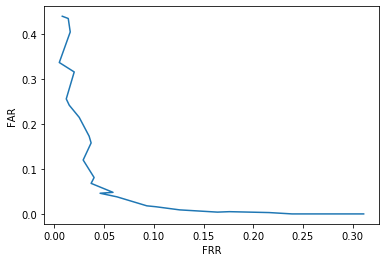

In [45]:
#1. train subject , train subject

counter_true_false_result(0,89, 0,89) 


60 . 
 91.25 % 
 true_result: 1825 false_result: 175 
 TP: 851 FN: 149 FRR: 0.149 
 TN: 974 FP: 26 FAR: 0.026 
 EER: 0.0875 

62 . 
 91.7 % 
 true_result: 1834 false_result: 166 
 TP: 868 FN: 132 FRR: 0.132 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.083 

64 . 
 92.55 % 
 true_result: 1851 false_result: 149 
 TP: 893 FN: 107 FRR: 0.107 
 TN: 958 FP: 42 FAR: 0.042 
 EER: 0.0745 

66 . 
 93.6 % 
 true_result: 1872 false_result: 128 
 TP: 938 FN: 62 FRR: 0.062 
 TN: 934 FP: 66 FAR: 0.066 
 EER: 0.064 

68 . 
 92.7 % 
 true_result: 1854 false_result: 146 
 TP: 930 FN: 70 FRR: 0.07 
 TN: 924 FP: 76 FAR: 0.076 
 EER: 0.07300000000000001 

70 . 
 92.2 % 
 true_result: 1844 false_result: 156 
 TP: 936 FN: 64 FRR: 0.064 
 TN: 908 FP: 92 FAR: 0.092 
 EER: 0.078 

72 . 
 92.25 % 
 true_result: 1845 false_result: 155 
 TP: 946 FN: 54 FRR: 0.054 
 TN: 899 FP: 101 FAR: 0.101 
 EER: 0.0775 

74 . 
 90.5 % 
 true_result: 1810 false_result: 190 
 TP: 941 FN: 59 FRR: 0.059 
 TN: 869 FP: 131 FAR: 0.131 
 EER: 

No handles with labels found to put in legend.


82 . 
 82.95 % 
 true_result: 1659 false_result: 341 
 TP: 976 FN: 24 FRR: 0.024 
 TN: 683 FP: 317 FAR: 0.317 
 EER: 0.1705 



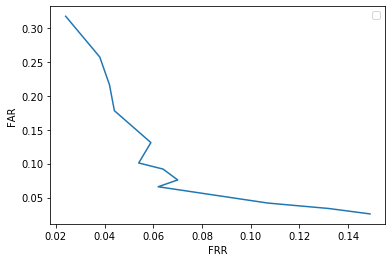

In [90]:
#2. train subject , new subject

counter_true_false_result(0,89, 90,108)


64 . 
 80.95 % 
 true_result: 1619 false_result: 381 
 TP: 714 FN: 286 FRR: 0.286 
 TN: 905 FP: 95 FAR: 0.095 
 EER: 0.1905 

66 . 
 82.4 % 
 true_result: 1648 false_result: 352 
 TP: 765 FN: 235 FRR: 0.235 
 TN: 883 FP: 117 FAR: 0.117 
 EER: 0.176 

68 . 
 84.25 % 
 true_result: 1685 false_result: 315 
 TP: 819 FN: 181 FRR: 0.181 
 TN: 866 FP: 134 FAR: 0.134 
 EER: 0.1575 

70 . 
 83.25 % 
 true_result: 1665 false_result: 335 
 TP: 833 FN: 167 FRR: 0.167 
 TN: 832 FP: 168 FAR: 0.168 
 EER: 0.1675 

72 . 
 81.05 % 
 true_result: 1621 false_result: 379 
 TP: 855 FN: 145 FRR: 0.145 
 TN: 766 FP: 234 FAR: 0.234 
 EER: 0.1895 



No handles with labels found to put in legend.


74 . 
 80.05 % 
 true_result: 1601 false_result: 399 
 TP: 883 FN: 117 FRR: 0.117 
 TN: 718 FP: 282 FAR: 0.282 
 EER: 0.19949999999999998 



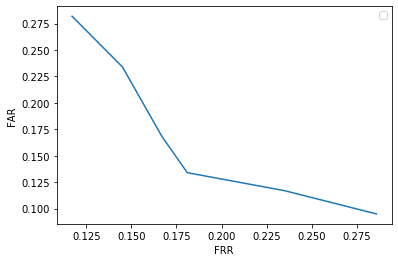

In [23]:
#3. new subject , new subject

counter_true_false_result(90,108, 90,108)


64 . 
 91.15 % 
 true_result: 1823 false_result: 177 
 TP: 847 FN: 153 FRR: 0.153 
 TN: 976 FP: 24 FAR: 0.024 
 EER: 0.0885 

66 . 
 93.15 % 
 true_result: 1863 false_result: 137 
 TP: 897 FN: 103 FRR: 0.103 
 TN: 966 FP: 34 FAR: 0.034 
 EER: 0.0685 

68 . 
 91.85 % 
 true_result: 1837 false_result: 163 
 TP: 882 FN: 118 FRR: 0.118 
 TN: 955 FP: 45 FAR: 0.045 
 EER: 0.08149999999999999 

70 . 
 91.9 % 
 true_result: 1838 false_result: 162 
 TP: 909 FN: 91 FRR: 0.091 
 TN: 929 FP: 71 FAR: 0.071 
 EER: 0.08099999999999999 

72 . 
 93.2 % 
 true_result: 1864 false_result: 136 
 TP: 950 FN: 50 FRR: 0.05 
 TN: 914 FP: 86 FAR: 0.086 
 EER: 0.068 



No handles with labels found to put in legend.


74 . 
 92.55 % 
 true_result: 1851 false_result: 149 
 TP: 937 FN: 63 FRR: 0.063 
 TN: 914 FP: 86 FAR: 0.086 
 EER: 0.0745 



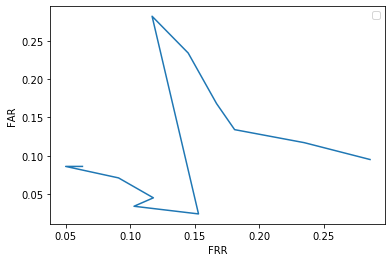

In [24]:
#4. all subject , all subject

counter_true_false_result(0,108, 0,108)


64 . 
 92.95 % 
 true_result: 1859 false_result: 141 
 TP: 876 FN: 124 FRR: 0.124 
 TN: 983 FP: 17 FAR: 0.017 
 EER: 0.07050000000000001 

66 . 
 93.05 % 
 true_result: 1861 false_result: 139 
 TP: 899 FN: 101 FRR: 0.101 
 TN: 962 FP: 38 FAR: 0.038 
 EER: 0.0695 

68 . 
 93.4 % 
 true_result: 1868 false_result: 132 
 TP: 916 FN: 84 FRR: 0.084 
 TN: 952 FP: 48 FAR: 0.048 
 EER: 0.066 

70 . 
 93.15 % 
 true_result: 1863 false_result: 137 
 TP: 921 FN: 79 FRR: 0.079 
 TN: 942 FP: 58 FAR: 0.058 
 EER: 0.0685 

72 . 
 92.3 % 
 true_result: 1846 false_result: 154 
 TP: 930 FN: 70 FRR: 0.07 
 TN: 916 FP: 84 FAR: 0.084 
 EER: 0.07700000000000001 

74 . 
 91.95 % 
 true_result: 1839 false_result: 161 
 TP: 940 FN: 60 FRR: 0.06 
 TN: 899 FP: 101 FAR: 0.101 
 EER: 0.0805 

76 . 
 91.0 % 
 true_result: 1820 false_result: 180 
 TP: 950 FN: 50 FRR: 0.05 
 TN: 870 FP: 130 FAR: 0.13 
 EER: 0.09 

78 . 
 90.25 % 
 true_result: 1805 false_result: 195 
 TP: 962 FN: 38 FRR: 0.038 
 TN: 843 FP: 157 FAR: 0

No handles with labels found to put in legend.


80 . 
 88.55 % 
 true_result: 1771 false_result: 229 
 TP: 956 FN: 44 FRR: 0.044 
 TN: 815 FP: 185 FAR: 0.185 
 EER: 0.11449999999999999 



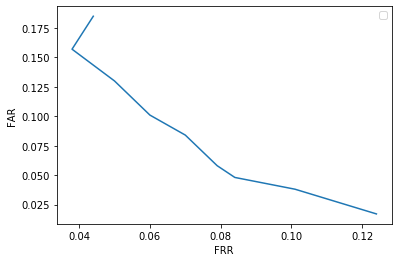

In [27]:
#4. all subject , all subject

counter_true_false_result(0,107, 0,108)